Colab Link - https://colab.research.google.com/drive/1JTdGZrIzgTAARaAqvY4KTS0whfzrL5D8?usp=sharing

# Gradient Boosting Classification

The Gradient Boosting (GB) algorithm trains a series of weak learners and each focuses on the errors the previous learners have made and tries to improve it. Together, they make a better prediction.



# Example 1

In [2]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_breast_cancer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import graphviz 
from sklearn import tree

In [3]:
df=pd.DataFrame()
df['name']=['Jumana','Jerry','Jacky','David','Eric','John']
df['likes_popcorn']=[1,1,0,1,0,0]
df['age']=[10,90,30,30,30,10]
df['favorite_color']=['Blue','Green','Blue','Red','Green','Blue']
df['loves_troll2']=[1,1,0,0,1,1]
print('Data:')
display(df)

X=df[['likes_popcorn','age']].copy()
X['blue']=0
X.loc[df['favorite_color']=='Blue','blue']=1
X['green']=0
X.loc[df['favorite_color']=='Green','blue']=1
X['red']=0
X.loc[df['favorite_color']=='Red','blue']=1

y=df['loves_troll2']
print('X:')
display(X)

n=df.shape[0]

Data:


,name,likes_popcorn,age,favorite_color,loves_troll2
0,Jumana,1,10,Blue,1
1,Jerry,1,90,Green,1
2,Jacky,0,30,Blue,0
3,David,1,30,Red,0
4,Eric,0,30,Green,1
5,John,0,10,Blue,1


X:


,likes_popcorn,age,blue,green,red
0,1,10,1,0,0
1,1,90,1,0,0
2,0,30,1,0,0
3,1,30,1,0,0
4,0,30,1,0,0
5,0,10,1,0,0


## Step 1 Log of Odds, Probabilities and Predictions

In [4]:
log_of_odds0=np.log(4 / 2)
probability0=np.exp(log_of_odds0)/(np.exp(log_of_odds0)+1)
print(f'the log_of_odds is : {log_of_odds0}')
print(f'the probability is : {probability0}')
predict0=1
print(f'the prediction is : 1')
n_samples=6

loss0=-(y*np.log(probability0)+(1-y)*np.log(1-probability0))

the log_of_odds is : 0.6931471805599453
the probability is : 0.6666666666666666
the prediction is : 1


In [5]:
n_times = 5
learning_rate=0.8
log_of_odds=np.zeros([n_times+1,n_samples])

residuals = np.zeros([n_times+1,n_samples])
loss = [0] * (n_times+1)
probabilities = np.zeros([n_times+1,n_samples])
predictions = np.zeros([n_times+1,n_samples])
score = np.zeros([n_times+1])
#calculation
log_of_odds[0] = [log_of_odds0] * n_samples
probabilities[0] = [probability0] * n_samples
predictions[0] = (probabilities[0]>0.5)*1.0
score[0]=np.sum(predictions[0]==y) / n_samples
residuals[0] = y - probabilities[0]
loss[0] = loss0.sum()
trees = []
gamma_value = np.zeros([n_times+1,8])
gamma = np.zeros([n_times+1,n_samples])

In [6]:
residuals.shape

(6, 6)

In [7]:
probabilities.shape

(6, 6)

In [8]:
def iteration(i):
    #Calculate the residuals
    residuals[i] = y - probabilities[i]
    #Fit a regression tree
    dt = DecisionTreeRegressor(max_depth=1, max_leaf_nodes=3)
    dt=dt.fit(X, residuals[i])
    
    trees.append(dt.tree_)
    
    #Calculate gamma
    leaf_indeces=dt.apply(X)
    print(leaf_indeces)
    unique_leaves=np.unique(leaf_indeces)
    n_leaf=len(unique_leaves)
    #for leaf 1
    for ileaf in range(n_leaf):
        
        leaf_index=unique_leaves[ileaf]
        n_leaf=len(leaf_indeces[leaf_indeces==leaf_index])
        previous_probability = probabilities[i][leaf_indeces==leaf_index]
        denominator = np.sum(previous_probability * (1-previous_probability))
        igamma = dt.tree_.value[ileaf+1][0][0] * n_leaf / denominator
        gamma_value[i][ileaf]=igamma
        print(f'for leaf {leaf_index}, we have {n_leaf} related samples. and gamma is {igamma}')

    gamma[i] = [gamma_value[i][np.where(unique_leaves==index)] for index in leaf_indeces]
    #Update F(x) 
    log_of_odds[i+1] = log_of_odds[i] + learning_rate * gamma[i]

    probabilities[i+1] = np.array([np.exp(odds)/(np.exp(odds)+1) for odds in log_of_odds[i+1]])
    predictions[i+1] = (probabilities[i+1]>0.5)*1.0
    score[i+1]=np.sum(predictions[i+1]==y) / n_samples
    #residuals[i+1] = y - probabilities[i+1]
    loss[i+1]=np.sum(-y * log_of_odds[i+1] + np.log(1+np.exp(log_of_odds[i+1])))
    
    new_df=df.copy()
    new_df.columns=['name', 'popcorn','age','color','y']
    new_df[f'$p_{i}$']=probabilities[i]
    new_df[f'$l_{i}$']=log_of_odds[i]
    new_df[f'$r_{i}$']=residuals[i]
    new_df[f'$\gamma_{i}$']=gamma[i]
    new_df[f'$l_{i+1}$']=log_of_odds[i+1]
    new_df[f'$p_{i+1}$']=probabilities[i+1]
    display(new_df)
    
    dot_data = tree.export_graphviz(dt, out_file=None, filled=True, rounded=True,feature_names=X.columns) 
    graph = graphviz.Source(dot_data) 
    display(graph)

[1 2 2 2 2 1]
for leaf 1, we have 2 related samples. and gamma is 1.5
for leaf 2, we have 4 related samples. and gamma is -0.7499999999999998


,name,popcorn,age,color,y,$p_0$,$l_0$,$r_0$,$\gamma_0$,$l_1$,$p_1$
0,Jumana,1,10,Blue,1,0.666667,0.693147,0.333333,1.50,1.893147,0.869114
1,Jerry,1,90,Green,1,0.666667,0.693147,0.333333,-0.75,0.093147,0.523270
2,Jacky,0,30,Blue,0,0.666667,0.693147,-0.666667,-0.75,0.093147,0.523270
3,David,1,30,Red,0,0.666667,0.693147,-0.666667,-0.75,0.093147,0.523270
4,Eric,0,30,Green,1,0.666667,0.693147,0.333333,-0.75,0.093147,0.523270
5,John,0,10,Blue,1,0.666667,0.693147,0.333333,1.50,1.893147,0.869114


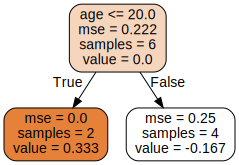

In [9]:
iteration(0)

In [10]:
(1/3+1/3)/((1-2/3)*2/3+(1-2/3)*2/3)

1.4999999999999998

  * For the second leaf, we have four samples. $\gamma$ is:

In [11]:
(1/3-2/3-2/3+1/3)/(4*(1-2/3)*2/3)

-0.75

[1 2 1 1 1 1]
for leaf 1, we have 5 related samples. and gamma is -0.31564962030401844
for leaf 2, we have 1 related samples. and gamma is 1.9110594001952543


,name,popcorn,age,color,y,$p_1$,$l_1$,$r_1$,$\gamma_1$,$l_2$,$p_2$
0,Jumana,1,10,Blue,1,0.869114,1.893147,0.130886,-0.315650,1.640627,0.837620
1,Jerry,1,90,Green,1,0.523270,0.093147,0.476730,1.911059,1.621995,0.835070
2,Jacky,0,30,Blue,0,0.523270,0.093147,-0.523270,-0.315650,-0.159373,0.460241
3,David,1,30,Red,0,0.523270,0.093147,-0.523270,-0.315650,-0.159373,0.460241
4,Eric,0,30,Green,1,0.523270,0.093147,0.476730,-0.315650,-0.159373,0.460241
5,John,0,10,Blue,1,0.869114,1.893147,0.130886,-0.315650,1.640627,0.837620


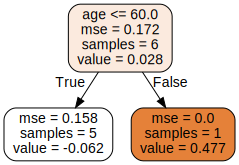

In [12]:
iteration(1)
    

In [13]:
sum_of_residual=0.130886+-0.523270+-0.523270+0.476730+0.130886
denominator=2*0.869114*(1-0.869114)+3*0.523270*(1-0.523270)
display(sum_of_residual/denominator)

-0.3156498224562022

In [14]:
0.476730/(0.523270*(1-0.523270))

1.9110593001700842

[1 2 2 2 2 1]
for leaf 1, we have 2 related samples. and gamma is 1.1938583610371274
for leaf 2, we have 4 related samples. and gamma is -0.24439014590890917


,name,popcorn,age,color,y,$p_2$,$l_2$,$r_2$,$\gamma_2$,$l_3$,$p_3$
0,Jumana,1,10,Blue,1,0.837620,1.640627,0.162380,1.193858,2.595714,0.930585
1,Jerry,1,90,Green,1,0.835070,1.621995,0.164930,-0.244390,1.426483,0.806353
2,Jacky,0,30,Blue,0,0.460241,-0.159373,-0.460241,-0.244390,-0.354885,0.412198
3,David,1,30,Red,0,0.460241,-0.159373,-0.460241,-0.244390,-0.354885,0.412198
4,Eric,0,30,Green,1,0.460241,-0.159373,0.539759,-0.244390,-0.354885,0.412198
5,John,0,10,Blue,1,0.837620,1.640627,0.162380,1.193858,2.595714,0.930585


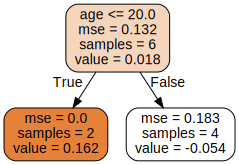

In [15]:
iteration(2)

[1 2 1 1 1 1]
for leaf 1, we have 5 related samples. and gamma is -0.11420357619360062
for leaf 2, we have 1 related samples. and gamma is 1.2401521534064346


,name,popcorn,age,color,y,$p_3$,$l_3$,$r_3$,$\gamma_3$,$l_4$,$p_4$
0,Jumana,1,10,Blue,1,0.930585,2.595714,0.069415,-0.114204,2.504351,0.924446
1,Jerry,1,90,Green,1,0.806353,1.426483,0.193647,1.240152,2.418604,0.918235
2,Jacky,0,30,Blue,0,0.412198,-0.354885,-0.412198,-0.114204,-0.446247,0.390253
3,David,1,30,Red,0,0.412198,-0.354885,-0.412198,-0.114204,-0.446247,0.390253
4,Eric,0,30,Green,1,0.412198,-0.354885,0.587802,-0.114204,-0.446247,0.390253
5,John,0,10,Blue,1,0.930585,2.595714,0.069415,-0.114204,2.504351,0.924446


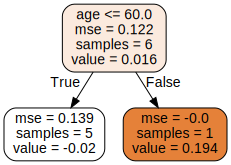

In [16]:
iteration(3)

[2 2 1 2 1 1]
for leaf 1, we have 3 related samples. and gamma is 0.5406201302738854
for leaf 2, we have 3 related samples. and gamma is -0.6083743125192569


,name,popcorn,age,color,y,$p_4$,$l_4$,$r_4$,$\gamma_4$,$l_5$,$p_5$
0,Jumana,1,10,Blue,1,0.924446,2.504351,0.075554,-0.608374,2.017652,0.882638
1,Jerry,1,90,Green,1,0.918235,2.418604,0.081765,-0.608374,1.931905,0.873460
2,Jacky,0,30,Blue,0,0.390253,-0.446247,-0.390253,0.540620,-0.013751,0.496562
3,David,1,30,Red,0,0.390253,-0.446247,-0.390253,-0.608374,-0.932947,0.282327
4,Eric,0,30,Green,1,0.390253,-0.446247,0.609747,0.540620,-0.013751,0.496562
5,John,0,10,Blue,1,0.924446,2.504351,0.075554,0.540620,2.936847,0.949638


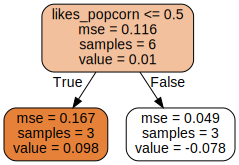

In [17]:
iteration(4)

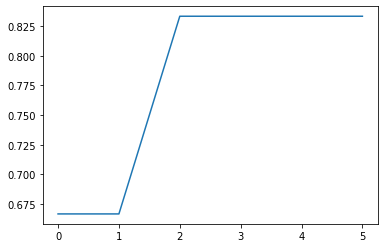

In [18]:
plt.plot(score)
plt.show()

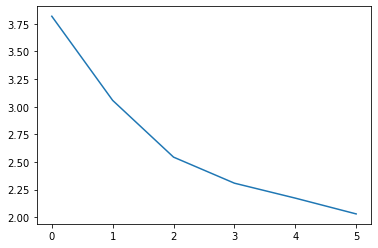

In [19]:
plt.plot(loss)
plt.show()

# Example 2 (Breast Cancer Dataset)
## Load data

In [20]:
cancer=load_breast_cancer()
n_samples = len(cancer.target)
X = cancer.data
y = cancer.target
total=len(y)
has_cancer=np.sum(y)
no_cancer=total-has_cancer
print(f'{has_cancer} out of {total} persons have cancer')
print(f'features {X.shape[1]}')

357 out of 569 persons have cancer
features 30


## Step 1 Log of Odds

In [21]:
log_of_odds0=np.log(has_cancer / no_cancer)
probability0=np.exp(log_of_odds0)/(np.exp(log_of_odds0)+1)
print(f'the log_of_odds is : {log_of_odds0}')
print(f'the probability is : {probability0}')
predict0=1

the log_of_odds is : 0.5211495071076265
the probability is : 0.6274165202108963


## Step 2 For Loop

In [22]:
residuals0=y - probability0
loss0=-(y*np.log(probability0)+(1-y)*np.log(1-probability0))
print(f'loss is {loss0.sum()}')
loss0=-y * log_of_odds0 + np.log(1+np.exp(log_of_odds0))
print(f'loss is {loss0.sum()}')

tree0 = DecisionTreeRegressor(max_depth=1)
tree0.fit(X, residuals0)
stem = tree0.tree_

leaf_index=tree0.apply(X)
#for leaf 1
n_leaf1=len(leaf_index[leaf_index==1])
previous_probability1 = np.array([probability0] * n_leaf1)
denominator1 = np.sum(previous_probability1 * (1-previous_probability1))
gamma1 = stem.value[1][0][0] * n_leaf1 / denominator1
print(f'gamma1 {gamma1}')
#for leaf 2
n_leaf2=len(leaf_index[leaf_index==2])
previous_probability2 = np.array([probability0] * n_leaf2)
denominator2 = np.sum(previous_probability2 * (1-previous_probability2))
gamma2 = stem.value[2][0][0] * n_leaf2 / denominator2
print(f'gamma2 {gamma2}')

gamma_value=[gamma1, gamma2]
gamma = np.array([gamma_value[index-1] for index in leaf_index])
new_log_of_odds = log_of_odds0 + 0.1 * gamma
new_loss=-y * new_log_of_odds + np.log(1+np.exp(new_log_of_odds))
print(f'new loss is {new_loss.sum()}')

loss is 375.7200026920845
loss is 375.72000269208445
gamma1 1.2213642015774746
gamma2 -2.4363001705150826
new loss is 338.1370338310421


In [23]:
n_times = 20
learning_rate=0.1
log_of_odds=np.zeros([n_times+1,n_samples])

residuals = np.zeros([n_times+1,n_samples])
loss = [0] * (n_times+1)
probabilities = np.zeros([n_times+1,n_samples])
score = np.zeros([n_times+1])
#calculation
log_of_odds[0] = [log_of_odds0] * n_samples
probabilities[0] = [probability0] * n_samples
score[0]=np.sum((probabilities[0]>0.5)*1.0==y) / n_samples
residuals[0] = y - probabilities[0]
loss[0] = loss0.sum()
trees = []
gamma_value = np.zeros([n_times+1,8])
gamma = np.zeros([n_times+1,n_samples])

In [ ]:
for i in range(n_times):
    dt = DecisionTreeRegressor(max_depth=2)
    dt=dt.fit(X, residuals[i])
    tree = dt.tree_
    trees.append(tree)
    leaf_indeces=dt.apply(X)
    unique_leaves=np.unique(leaf_indeces)
    n_leaf=len(unique_leaves)
    #for leaf 1
    for ileaf in range(n_leaf):
        leaf_index=unique_leaves[ileaf]
        n_leaf=len(leaf_indeces[leaf_indeces==leaf_index])
        previous_probability = probabilities[i][leaf_indeces==leaf_index]
        denominator = np.sum(previous_probability * (1-previous_probability))
        igamma = tree.value[ileaf+1][0][0] * n_leaf / denominator
        gamma_value[i][ileaf]=igamma

    gamma[i] = [gamma_value[i][np.where(unique_leaves==index)] for index in leaf_indeces]
    #next 
    log_of_odds[i+1] = log_of_odds[i] + learning_rate * gamma[i]

    probabilities[i+1] = np.array([np.exp(odds)/(np.exp(odds)+1) for odds in log_of_odds[i+1]])
    score[i+1]=np.sum((probabilities[i+1]>0.5)*1.0==y) / n_samples
    residuals[i+1] = y - probabilities[i+1]
    loss[i+1]=np.sum(-y * log_of_odds[i+1] + np.log(1+np.exp(log_of_odds[i+1])))

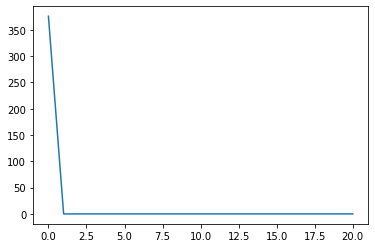

In [24]:
plt.plot(loss)
plt.show()

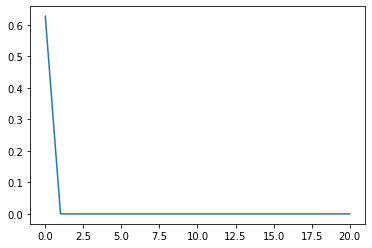

In [25]:
plt.plot(score)
plt.show()